# RNN航空公司评论分类

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tf.__version__

'2.0.0'

In [2]:
data = pd.read_csv("dataset/Tweets.csv")

In [3]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
# 评价的数量统计
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [5]:
# 三类评价各取2300条
train_num = 2300
data_pos = data[data.airline_sentiment == 'positive'].iloc[:train_num]
data_neg = data[data.airline_sentiment == 'negative'].iloc[:train_num]
data_neu = data[data.airline_sentiment == 'neutral'].iloc[:train_num]
# 连接data
data = pd.concat([data_pos, data_neg, data_neu])
data.airline_sentiment.value_counts()

neutral     2300
negative    2300
positive    2300
Name: airline_sentiment, dtype: int64

### 处理label

In [6]:
# 创建label_to_index字典
label_to_index = dict((label, index) for index, label in enumerate(set(data['airline_sentiment'])))
label_to_index

{'negative': 0, 'neutral': 1, 'positive': 2}

In [7]:
# 通过随机采样打乱数据
data = data.sample(len(data))
# 将label转为对应index
data['airline_sentiment'] = data.airline_sentiment.apply(lambda x: label_to_index[x])
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
7070,569940702425169920,1,0.6617,NaN,0.0000,Delta,NaN,ohhnamrata,NaN,0,No. RT @JetBlue Our fleet's on fleek.,NaN,2015-02-23 11:23:47 -0800,NYC,Eastern Time (US & Canada)
7432,569614500044918784,2,0.6472,NaN,NaN,Delta,NaN,ChrisDonahoe,NaN,0,"@JetBlue btw, Robin Hayes is speaking at next ...",NaN,2015-02-22 13:47:34 -0800,"Washington, D.C.",Quito
5755,568664266502479872,2,1.0000,NaN,NaN,Southwest,NaN,JaylynCoffin,NaN,0,@SouthwestAir was fantastic! That's the best f...,NaN,2015-02-19 22:51:41 -0800,Orlando Florida. (Winter Park),NaN
1552,569666686086819840,0,1.0000,Can't Tell,0.6594,United,NaN,mckakia,NaN,0,@united: thanks for the miserable trip GNV&lt...,NaN,2015-02-22 17:14:56 -0800,NaN,NaN
5829,568567255291703298,2,0.6819,NaN,NaN,Southwest,NaN,itsjessme_,NaN,0,"@SouthwestAir Sorry to spam, it would just be ...",NaN,2015-02-19 16:26:11 -0800,NaN,Alaska


In [8]:
# 从data中取出label
data_label = data.airline_sentiment.values
data_label

array([1, 2, 2, ..., 2, 2, 2], dtype=int64)

### 处理text

#### 将文本分离成单词

In [9]:
import re

In [10]:
# 用正则表达式提取单词和常见符号
# [ ] ：字符集，对单个字符给出取值范围
# + ：前一个字符1次或无限次扩展
# | ：左右表达式任意一个
token = re.compile('[A-Za-z]+|[!?,.()]')

In [11]:
def reg_text(text):
    # 搜索字符串，以列表类型返回全部能匹配的子串
    new_text = token.findall(text)
    # 将单词转为小写
    new_text = [word.lower() for word in new_text]
    return new_text

data['text'] = data.text.apply(reg_text)
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
7070,569940702425169920,1,0.6617,NaN,0.0000,Delta,NaN,ohhnamrata,NaN,0,"[no, ., rt, jetblue, our, fleet, s, on, fleek, .]",NaN,2015-02-23 11:23:47 -0800,NYC,Eastern Time (US & Canada)
7432,569614500044918784,2,0.6472,NaN,NaN,Delta,NaN,ChrisDonahoe,NaN,0,"[jetblue, btw, ,, robin, hayes, is, speaking, ...",NaN,2015-02-22 13:47:34 -0800,"Washington, D.C.",Quito
5755,568664266502479872,2,1.0000,NaN,NaN,Southwest,NaN,JaylynCoffin,NaN,0,"[southwestair, was, fantastic, !, that, s, the...",NaN,2015-02-19 22:51:41 -0800,Orlando Florida. (Winter Park),NaN
1552,569666686086819840,0,1.0000,Can't Tell,0.6594,United,NaN,mckakia,NaN,0,"[united, thanks, for, the, miserable, trip, gn...",NaN,2015-02-22 17:14:56 -0800,NaN,NaN
5829,568567255291703298,2,0.6819,NaN,NaN,Southwest,NaN,itsjessme_,NaN,0,"[southwestair, sorry, to, spam, ,, it, would, ...",NaN,2015-02-19 16:26:11 -0800,NaN,Alaska


#### 将单词编码成序号，序号从1开始，0作为填充

In [12]:
# 建立单词集合
word_set = set()
for text in data['text']:
    for word in text:
        word_set.add(word)
# 单词数为word_set的长度加1
num_word = len(word_set) + 1

In [13]:
word_to_index = dict((word, index+1) for index, word in enumerate(word_set))
list(word_to_index.items())[:5]

[('flew', 1),
 ('sarcastically', 2),
 ('buybacks', 3),
 ('expeditious', 4),
 ('gerri', 5)]

In [14]:
data['text'] = data.text.apply(lambda x: [word_to_index[word] for word in x])
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
7070,569940702425169920,1,0.6617,NaN,0.0000,Delta,NaN,ohhnamrata,NaN,0,"[2998, 426, 7769, 8281, 1197, 5458, 4257, 4596...",NaN,2015-02-23 11:23:47 -0800,NYC,Eastern Time (US & Canada)
7432,569614500044918784,2,0.6472,NaN,NaN,Delta,NaN,ChrisDonahoe,NaN,0,"[8281, 1079, 4294, 860, 8512, 8623, 6943, 8686...",NaN,2015-02-22 13:47:34 -0800,"Washington, D.C.",Quito
5755,568664266502479872,2,1.0000,NaN,NaN,Southwest,NaN,JaylynCoffin,NaN,0,"[3232, 2691, 7449, 8263, 7333, 4257, 6707, 600...",NaN,2015-02-19 22:51:41 -0800,Orlando Florida. (Winter Park),NaN
1552,569666686086819840,0,1.0000,Can't Tell,0.6594,United,NaN,mckakia,NaN,0,"[4585, 6715, 8635, 6707, 2744, 5731, 6987, 850...",NaN,2015-02-22 17:14:56 -0800,NaN,NaN
5829,568567255291703298,2,0.6819,NaN,NaN,Southwest,NaN,itsjessme_,NaN,0,"[3232, 7513, 4781, 4326, 4294, 5945, 8201, 213...",NaN,2015-02-19 16:26:11 -0800,NaN,Alaska


In [15]:
# 从data中取出text
data_text = data.text.values
data_text

array([list([2998, 426, 7769, 8281, 1197, 5458, 4257, 4596, 3673, 426]),
       list([8281, 1079, 4294, 860, 8512, 8623, 6943, 8686, 476, 6546, 4257, 1809, 788, 2156, 426, 1896, 7391, 4781, 3196, 193, 1370, 2238, 4781, 4337, 1793, 4216, 426, 7065, 2129]),
       list([3232, 2691, 7449, 8263, 7333, 4257, 6707, 600, 6154, 6306, 2570, 8630, 5210, 5133, 426]),
       ...,
       list([1417, 932, 6705, 4491, 8686, 6707, 6439, 4801, 1542, 4006, 499, 2365, 5261, 7109, 9149, 1498, 5841, 1197, 6154, 8263]),
       list([7056, 6715, 4781, 6707, 3362, 4216, 8635, 5886, 4596, 1127, 6154, 2005, 1316, 48, 881, 8225, 426, 6718, 6156]),
       list([8281, 3623, 3134, 6990, 8686, 5799, 426, 739, 6285, 193, 451, 5160, 426, 2677, 4846, 2234, 5069, 7892])],
      dtype=object)

In [16]:
# 找出最长文本长度
max_len = max(len(txt) for txt in data_text)
data_text = tf.keras.preprocessing.sequence.pad_sequences(data_text, max_len)
data_text

array([[   0,    0,    0, ..., 4596, 3673,  426],
       [   0,    0,    0, ...,  426, 7065, 2129],
       [   0,    0,    0, ..., 5210, 5133,  426],
       ...,
       [   0,    0,    0, ..., 1197, 6154, 8263],
       [   0,    0,    0, ...,  426, 6718, 6156],
       [   0,    0,    0, ..., 2234, 5069, 7892]])

### 创建模型训练

In [17]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=num_word,
                           output_dim=50,
                           input_length=max_len))
model.add(layers.LSTM(64))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 50)            467050    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 496,685
Trainable params: 496,685
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)
train = model.fit(data_text, data_label, epochs=10, batch_size=128, validation_split=0.2)

Train on 5520 samples, validate on 1380 samples
Epoch 1/10
5520/5520 [==============================] - 7s 1ms/sample - loss: 1.0229 - accuracy: 0.5324 - val_loss: 0.9113 - val_accuracy: 0.5754
Epoch 2/10
5520/5520 [==============================] - 1s 132us/sample - loss: 0.6570 - accuracy: 0.7373 - val_loss: 0.5663 - val_accuracy: 0.7630
Epoch 3/10
5520/5520 [==============================] - 1s 131us/sample - loss: 0.3894 - accuracy: 0.8516 - val_loss: 0.6011 - val_accuracy: 0.7616
Epoch 4/10
5520/5520 [==============================] - 1s 128us/sample - loss: 0.2959 - accuracy: 0.8957 - val_loss: 0.6457 - val_accuracy: 0.7652
Epoch 5/10
5520/5520 [==============================] - 1s 125us/sample - loss: 0.2055 - accuracy: 0.9284 - val_loss: 0.6099 - val_accuracy: 0.7986
Epoch 6/10
5520/5520 [==============================] - 1s 108us/sample - loss: 0.1542 - accuracy: 0.9493 - val_loss: 0.6745 - val_accuracy: 0.7754
Epoch 7/10
5520/5520 [==============================] - 1s 120us/s

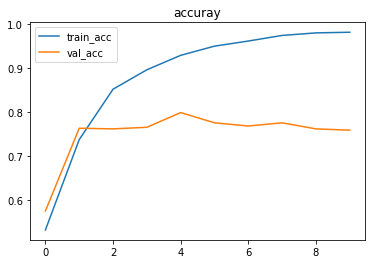

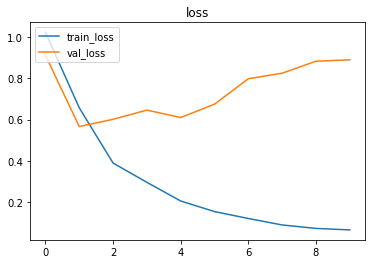

In [19]:
# 训练过程可视化
train_acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
train_loss = train.history['loss']
val_loss = train.history['val_loss']

plt.title("accuray")
plt.plot(train.epoch, train_acc, label='train_acc')
plt.plot(train.epoch, val_acc, label='val_acc')
plt.legend(loc='upper left')

plt.figure()
plt.title("loss")
plt.plot(train.epoch, train_loss, label='train_loss')
plt.plot(train.epoch, val_loss, label='val_loss')
plt.legend(loc='upper left')

### 使用 dropout 抑制过拟合

In [20]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=num_word,
                           output_dim=50,
                           input_length=max_len))
# 双层LSTM加dropout
model.add(layers.LSTM(32, dropout=0.2, return_sequences=True))
model.add(layers.LSTM(64, dropout=0.2))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 50)            467050    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 32)            10624     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 502,701
Trainable params: 502,701
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer="rmsprop",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)
train = model.fit(data_text, data_label, epochs=10, batch_size=128, validation_split=0.2)

Train on 5520 samples, validate on 1380 samples
Epoch 1/10
5520/5520 [==============================] - 5s 945us/sample - loss: 0.9490 - accuracy: 0.5065 - val_loss: 0.9622 - val_accuracy: 0.5913
Epoch 2/10
5520/5520 [==============================] - 1s 147us/sample - loss: 0.7146 - accuracy: 0.6601 - val_loss: 0.6983 - val_accuracy: 0.6826
Epoch 3/10
5520/5520 [==============================] - 1s 151us/sample - loss: 0.5519 - accuracy: 0.7736 - val_loss: 0.6178 - val_accuracy: 0.7188
Epoch 4/10
5520/5520 [==============================] - 1s 158us/sample - loss: 0.4431 - accuracy: 0.8310 - val_loss: 0.5917 - val_accuracy: 0.7681
Epoch 5/10
5520/5520 [==============================] - 1s 148us/sample - loss: 0.3739 - accuracy: 0.8567 - val_loss: 0.6444 - val_accuracy: 0.7572
Epoch 6/10
5520/5520 [==============================] - 1s 162us/sample - loss: 0.3089 - accuracy: 0.8833 - val_loss: 0.6983 - val_accuracy: 0.7623
Epoch 7/10
5520/5520 [==============================] - 1s 164us

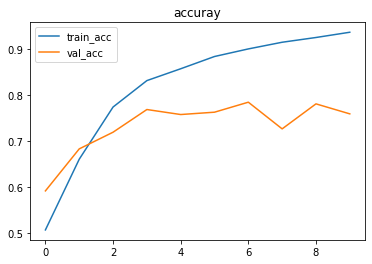

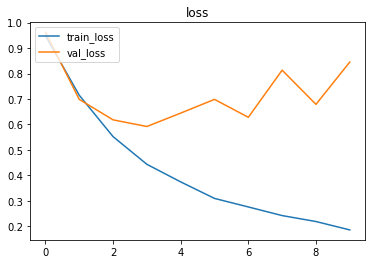

In [22]:
# 训练过程可视化
train_acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
train_loss = train.history['loss']
val_loss = train.history['val_loss']

plt.title("accuray")
plt.plot(train.epoch, train_acc, label='train_acc')
plt.plot(train.epoch, val_acc, label='val_acc')
plt.legend(loc='upper left')

plt.figure()
plt.title("loss")
plt.plot(train.epoch, train_loss, label='train_loss')
plt.plot(train.epoch, val_loss, label='val_loss')
plt.legend(loc='upper left')

### 使用双向 RNN

In [23]:
model = tf.keras.Sequential()
model.add(layers.Embedding(input_dim=num_word,
                           output_dim=50,
                           input_length=max_len))
model.add(layers.Bidirectional(layers.LSTM(64, dropout=0.2)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 40, 50)            467050    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 387       
Total params: 526,317
Trainable params: 526,317
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.compile(optimizer="rmsprop",
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)
# 学习率衰减
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.3, min_lr=0.00001, verbose=1)
train = model.fit(data_text, 
                  data_label, 
                  epochs=10, 
                  batch_size=128, 
                  validation_split=0.2,
                  callbacks=[learning_rate_reduction])

Train on 5520 samples, validate on 1380 samples
Epoch 1/10
5520/5520 [==============================] - 6s 1ms/sample - loss: 1.0078 - accuracy: 0.4889 - val_loss: 0.9908 - val_accuracy: 0.4891
Epoch 2/10
5520/5520 [==============================] - 1s 203us/sample - loss: 0.7167 - accuracy: 0.6770 - val_loss: 0.7471 - val_accuracy: 0.6362
Epoch 3/10
5520/5520 [==============================] - 1s 185us/sample - loss: 0.5473 - accuracy: 0.7768 - val_loss: 0.5901 - val_accuracy: 0.7659
Epoch 4/10
5520/5520 [==============================] - 1s 153us/sample - loss: 0.4422 - accuracy: 0.8313 - val_loss: 0.6720 - val_accuracy: 0.7297
Epoch 5/10
5120/5520 [==========================>...] - ETA: 0s - loss: 0.3632 - accuracy: 0.8617
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
5520/5520 [==============================] - 1s 150us/sample - loss: 0.3615 - accuracy: 0.8632 - val_loss: 0.6637 - val_accuracy: 0.7630
Epoch 6/10
5520/5520 [=========================

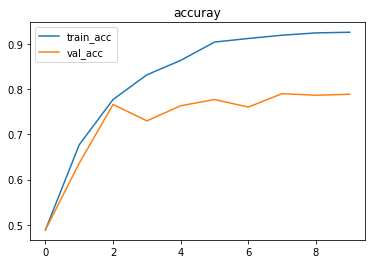

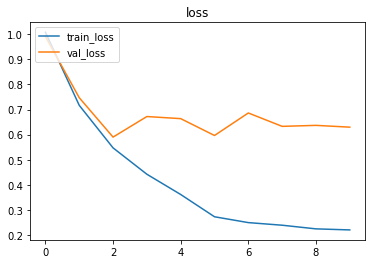

In [25]:
# 训练过程可视化
train_acc = train.history['accuracy']
val_acc = train.history['val_accuracy']
train_loss = train.history['loss']
val_loss = train.history['val_loss']

plt.title("accuray")
plt.plot(train.epoch, train_acc, label='train_acc')
plt.plot(train.epoch, val_acc, label='val_acc')
plt.legend(loc='upper left')

plt.figure()
plt.title("loss")
plt.plot(train.epoch, train_loss, label='train_loss')
plt.plot(train.epoch, val_loss, label='val_loss')
plt.legend(loc='upper left')